In [1]:
import sys
sys.path.append('../')

import numpy as np
from numpy.typing import NDArray
from dataclasses import dataclass
from typing import Callable
import matplotlib.pyplot as plt
import itertools

from ray_delay.ray_detector import RayDetectorSpec
from stim_surface_code import patch

After the high-accuracy simulations in notebooks 02-05, we are now zooming out
to look at algorithm-level performance. To do this, we must abandon Stim
simulations and instead adopt a simpler model of cosmic rays.

In [2]:
class MagicStateFactory:
    """TODO
    """
    def __init__(
            self, 
            dx: int = 7,
            dz: int = 7,
            dm: int = 7,
        ):
        """Initializes the factory.

        Args:
            dx: X code distance for each patch.
            dz: Z code distance for each patch.
            dm: Temporal code distance.
        """
        self.dx = dx
        self.dz = dz
        self.dm = dm

@dataclass
class SimulationResult:
    """Contains the results of a many-round magic state factory simulation.

    Attributes:
        TODO
    """
    ray_history: list[tuple[int, tuple[int, int]]]

def boolean_array_BFS(
        array: NDArray, 
        start: tuple[int, int], 
        end: tuple[int, int] | None = None,
    ) -> dict[tuple[int, int], list[tuple[int, int]]] | list[tuple[int, int]] | None:
    """Use breadth-first search to find a path through the array from start to
    end. False values in the array are considered obstacles.

    Args:
        array: 2D boolean array.
        start: Starting coordinates.
        end: Ending coordinates, or None to find all paths.
    
    Returns:
        If end is None, a dictionary of all paths from start to any True
        coordinate pair in the array. If end is not None, a list of coordinates
        representing the shortest path from start to end, or None if there is no
        path. 
    """
    frontier = [start]
    paths_to = {start: [start]}
    while len(frontier) > 0:
        current = frontier[0]
        frontier = frontier[1:]
        if current == end:
            break
        neighbors = [
            (current[0]+1, current[1]), 
            (current[0]-1, current[1]), 
            (current[0], current[1]+1), 
            (current[0], current[1]-1)
        ]
        for n in neighbors:
            if n not in paths_to and n[0] >= 0 and n[0] < array.shape[0] and n[1] >= 0 and n[1] < array.shape[1] and array[n]:
                paths_to[n] = paths_to[current] + [n]
                frontier.append(n)

    if end is None:
        return paths_to
    else:
        if end not in paths_to:
            return None
        else:
            return paths_to[end]

def boolean_array_all_pairs_BFS(array: NDArray) -> dict[tuple[int, int], dict[tuple[int, int], list[tuple[int, int]]]]:
    """Compute all pairs shortest paths.
    
    TODO
    """
    all_paths = {}
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i,j]:
                all_paths[(i,j)] = boolean_array_BFS(array, (i,j))
    return all_paths

class Redundant15To1(MagicStateFactory):
    """TODO
    """
    def __init__(
            self, 
            dx: int = 7,
            dz: int = 7,
            dm: int = 7,
            num_redundant_cols: int = 0,
            redundant_top_routing_space: int = 0,
            redundant_bot_routing_space: int = 0,
        ):
        """Initializes the factory, using a layout from litinski_magic_2019.

        Args:
            dx: X code distance for each patch.
            dz: Z code distance for each patch.
            dm: Temporal code distance.
            num_redundant_cols: Number of redundant patches to include.
        """
        super().__init__(dx, dz, dm)

        self.logical_qubit_row = 1 + redundant_top_routing_space

        num_rows = 3 + redundant_top_routing_space + redundant_bot_routing_space
        num_cols = 5 + num_redundant_cols
        row_heights = np.full(num_rows, self.dx)
        col_widths = np.array([self.dx] + [self.dz]*4 + [self.dx]*num_redundant_cols)

        self.num_patches = num_rows * num_cols
        self.patch_indices = np.reshape(np.arange(self.num_patches), (num_rows, num_cols))
        self.patch_coords_from_idx = np.zeros((self.num_patches, 2), int)
        for idx in range(self.num_patches):
            self.patch_coords_from_idx[idx] = [idx // self.patch_indices.shape[1], idx % self.patch_indices.shape[1]]
        self.patches_online = np.ones(self.num_patches, dtype=bool)

        # use stim_surface_code.patch to generate the physical qubit array
        # TODO: currently does not account for extra 4*dm space needed for magic
        # state injection (see figs. 10-11 of Litinski). Is this important?
        surface_code_patch = patch.SurfaceCodePatch(num_rows*dx + (num_rows-1), (1+num_redundant_cols)*dx + 4*dz + (num_cols-1), dm)
        self.physical_qubit_array = np.array([[(q.idx if q is not None else -1) for q in row] for row in surface_code_patch.device], int)
        self.physical_qubit_coords_from_idx = np.zeros((len(surface_code_patch.all_qubits), 2), int)
        for q in surface_code_patch.all_qubits:
            self.physical_qubit_coords_from_idx[q.idx] = q.coords

        # maps each physical qubit to a patch index
        self.patch_idx_from_physical_qubit_idx = np.full(len(surface_code_patch.all_qubits), -1, dtype=int)
        for row in range(num_rows):
            min_phys_row = np.sum(2*row_heights[:row]+1) + row
            max_phys_row = min_phys_row + 2*row_heights[row]+1
            for col in range(num_cols):
                min_phys_col = np.sum(2*col_widths[:col]+1) + col
                max_phys_col = min_phys_col + 2*col_widths[col]+1
                for phys_row in range(min_phys_row, max_phys_row):
                    for phys_col in range(min_phys_col, max_phys_col):
                        phys_idx = self.physical_qubit_array[phys_row, phys_col]
                        if phys_idx != -1:
                            self.patch_idx_from_physical_qubit_idx[phys_idx] = self.patch_indices[row, col]

    def _cycles_per_distillation(self) -> int | None:
        """Calculate the number of cycles required for one magic state
        distillation, based on the current state of self.patches_online.
        
        Returns:
            The number of surface code stabilizer measurement cycles required
            for one magic state distillation, or None if the factory cannot
            currently produce magic states.
        """
        # need a minimum of 5 logical qubits (middle row) online
        logical_qubits_online = []
        for idx, online in enumerate(self.patches_online):
            if online and self.patch_coords_from_idx[idx][0] == self.logical_qubit_row:
                logical_qubits_online.append(idx)

        if len(logical_qubits_online) < 5:
            return None

        # count how many routing spaces are fully available
        best_routing_spaces_found = 0
        all_pairs_paths_top = boolean_array_all_pairs_BFS(self.patches_online[self.patch_indices[:self.logical_qubit_row, :]])
        all_pairs_paths_bot = boolean_array_all_pairs_BFS(self.patches_online[self.patch_indices[self.logical_qubit_row+1:, :]])
        # try all combinations of 5 logical qubits
        for patch_idx_combo in itertools.combinations(logical_qubits_online, 5):
            # assume it is connected; we will verify for each pair of patches
            all_connected_top = True
            all_connected_bot = True
            # check for continuous group of online routing space patches for
            # each pair of patches
            for i,patch_1 in enumerate(patch_idx_combo):
                for patch_2 in patch_idx_combo[i+1:]:
                    start_col = min(self.patch_coords_from_idx[patch_1][1], self.patch_coords_from_idx[patch_2][1])
                    end_col = max(self.patch_coords_from_idx[patch_1][1], self.patch_coords_from_idx[patch_2][1])

                    # TODO: even if some patches are blocked for top routing
                    # space, others could still communicate - maybe not as bad
                    # as 2x overhead
                    # use BFS to find shortest path
                    if all_connected_top:
                        starting_coords = (self.logical_qubit_row-1, start_col)
                        ending_coords = (self.logical_qubit_row-1, end_col)
                        if self.patches_online[self.patch_indices[starting_coords]] and self.patches_online[self.patch_indices[ending_coords]]:
                            all_connected_top = ending_coords in all_pairs_paths_top[starting_coords]
                        else:
                            all_connected_top = False
                    if all_connected_bot:
                        starting_coords = (self.logical_qubit_row+1, start_col)
                        ending_coords = (self.logical_qubit_row+1, end_col)
                        if self.patches_online[self.patch_indices[starting_coords]] and self.patches_online[self.patch_indices[ending_coords]]:
                            starting_coords_relative = (0, start_col)
                            ending_coords_relative = (0, end_col)
                            all_connected_bot = ending_coords_relative in all_pairs_paths_bot[starting_coords_relative]
                        else:
                            all_connected_bot = False

                    if not all_connected_top and not all_connected_bot:
                        # failed, no need to check any more
                        break

            # if this is the best we have seen, save it
            routing_spaces_found = int(all_connected_top) + int(all_connected_bot)
            if routing_spaces_found > best_routing_spaces_found:
                five_patches_connected_top = all_connected_top
                five_patches_connected_bot = all_connected_bot
                best_routing_spaces_found = routing_spaces_found
        
        assert best_routing_spaces_found in [0, 1, 2]

        if best_routing_spaces_found == 0:
            return None
        elif best_routing_spaces_found == 1:
            return 12*self.dm
        else:
            return 6*self.dm
        
    def _simulate(
            self, 
            num_distillations: int,
            ray_incidence_rate: float,
            ray_detector_spec: RayDetectorSpec,
            patch_offline_time: float,
        ):
        """Simulate the performance of the factory over a number of rounds, with
        cosmic rays.
        
        Args:
            num_distillations: Number of distillations to simulate.
            ray_incidence_rate: Chance of a ray per qubit per second.
            ray_detector_spec: Contains information about ray and detector
                behavior.
            patch_offline_time: Amount of time (in seconds) a patch is taken
                offline when a ray is detected.
            
        Returns:
            TODO
        """
        # calculate baseline chances of patches being turned offline (when no
        # ray present)
        
        raise NotImplementedError

    def _calc_patch_offline_chances(
            self,
            ray_incidence_qubit: int,
            cycles_after_ray_impact: int,
            detection_chance_function: Callable[[float, int], float],
        ) -> NDArray:
        """Calculate the chance that each patch is turned offline due to a ray
        event.

        Args:
            ray_incidence_qubit: Index of the qubit where the ray is incident.
            cycles_after_ray_impact: Number of cycles that have occurred since
                the ray impact. 0 indicates that there is no ray.
            detection_chance_function: Encodes each physical qubit's chance to
                detect the ray, as a function of the distance from the center of
                the ray (in qubit-spacings) and the number of cycles since the
                ray impacted. Chance is per surface code cycle.
        
        Returns:
            1D array of length self.num_patches, where each entry is the chance
            that the corresponding patch is taken offline due to a ray event.
        """
        ray_incidence_coords = self.physical_qubit_coords_from_idx[ray_incidence_qubit]
        physical_qubit_distances_from_ray = np.linalg.norm(self.physical_qubit_coords_from_idx - ray_incidence_coords, axis=1)
        
        
        
        raise NotImplementedError

In [3]:
# test cycles_per_distillation

dm = 7

# test non-redundant
factory = Redundant15To1(dm=dm)
assert factory._cycles_per_distillation() == 6*dm
for offline_patch in range(factory.num_patches):
    factory.patches_online = np.ones(factory.patches_online.shape, bool)

    # one offline patch
    row = factory.patch_coords_from_idx[offline_patch][0]
    factory.patches_online[offline_patch] = False
    if row == 1:
        assert factory._cycles_per_distillation() is None
    else:
        assert factory._cycles_per_distillation() == 12*dm

    # check with two offline patches
    factory.patches_online[0] = False
    if row == 0:
        assert factory._cycles_per_distillation() == 12*dm
    elif row == 1:
        assert factory._cycles_per_distillation() is None
    else:
        assert factory._cycles_per_distillation() is None

# test redundancy
factory = Redundant15To1(dm=dm, num_redundant_cols=1)
for offline_patch in range(factory.num_patches):
    factory.patches_online = np.ones(factory.patches_online.shape, bool)

    # one offline patch
    row = factory.patch_coords_from_idx[offline_patch][0]
    col = factory.patch_coords_from_idx[offline_patch][1]
    factory.patches_online[offline_patch] = False
    if row == 1:
        # one logical qubit offline: not a problem
        assert factory._cycles_per_distillation() is 6*dm
    else:
        if col == 0 or col == 5:
            # does not affect factory
            assert factory._cycles_per_distillation() == 6*dm
        else:
            # cannot route around on one side
            assert factory._cycles_per_distillation() == 12*dm

    # check additional offline routing patch
    factory.patches_online[0] = False
    if row == 0 and offline_patch != 0:
        # two offline in top row; can't use top
        assert factory._cycles_per_distillation() == 12*dm
    elif row == 1:
        if col == 0:
            # routing space not blocked
            assert factory._cycles_per_distillation() == 6*dm
        else:
            # top routing space blocked
            assert factory._cycles_per_distillation() == 12*dm
    else:
        # can either use only top or both
        if col == 0:
            assert factory._cycles_per_distillation() == 6*dm
        else:
            # can only use one
            assert factory._cycles_per_distillation() == 12*dm
    factory.patches_online[0] = True

    # check additional offline logical patch
    factory.patches_online[6] = False
    if row == 0 or row == 2:
        if col == 0:
            # routing space not blocked
            assert factory._cycles_per_distillation() == 6*dm
        else:
            # one routing space blocked
            assert factory._cycles_per_distillation() == 12*dm
    elif row == 1 and offline_patch != 6:
        # two logical offline; can't distill
        assert factory._cycles_per_distillation() is None

In [4]:
factory = Redundant15To1(dx=5, dz=3, dm=dm, num_redundant_cols=1, redundant_bot_routing_space=1)

In [5]:
factory.patches_online[[0,11,17]] = False

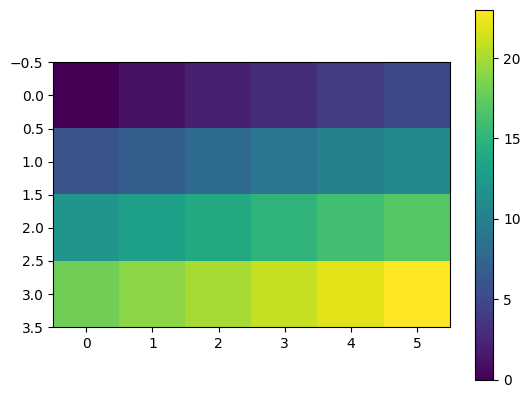

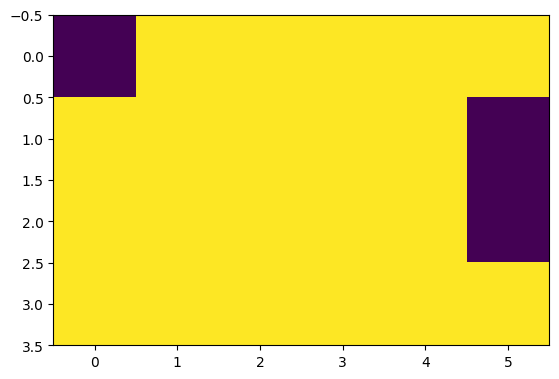

In [6]:
plt.imshow(factory.patch_indices)
plt.colorbar()
plt.show()
plt.imshow(factory.patches_online[factory.patch_indices])
plt.show()

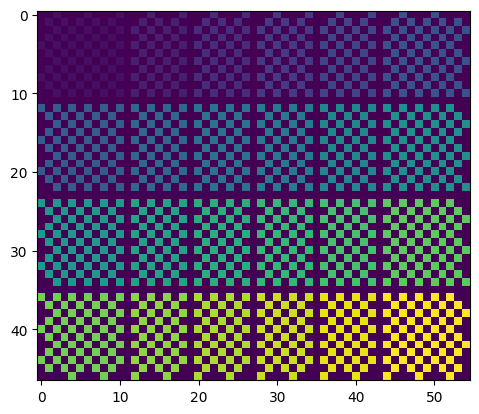

In [7]:
phys_qubit_labels = np.full(factory.physical_qubit_array.shape, -1, dtype=int)
for idx,coords in enumerate(factory.physical_qubit_coords_from_idx):
    phys_qubit_labels[coords[0], coords[1]] = factory.patch_idx_from_physical_qubit_idx[idx]

plt.imshow(phys_qubit_labels)

In [8]:
factory._cycles_per_distillation()

84

In [11]:
factory = Redundant15To1(dx=5, dz=3, dm=dm)

In [12]:
2*(factory.dx + 4*factory.dz) * 3*factory.dz + 4*factory.dm

334

In [13]:
len(factory.physical_qubit_coords_from_idx)

713